# Educational Migration:
## Studying the Neighbourhood Amenities of Ljubljana & Maribor (Slovenia) and Villach & Graz (Austria)


Code for the data analysis of Ljubljana, Villach, Maribor & Graz

## 4. Packages for Data Processing and Analysis

In [1]:
!pip install geopy
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

## Cities Analysed

4.1 - Ljubljana

4.2 - Villach

4.3 - Maribor

4.4 - Graz

## 4.1 Data Collection - Ljubljana

District & Lat/Lon dataframe

In [3]:
df_LL = pd.read_csv (r'https://raw.githubusercontent.com/nicwhitehead/IBM-Data-Science-Capstone-Project/main/Districts_and_Postcodes.csv')
#Limited to Ljubljana for example purposes
Ljubljana = df_LL[df_LL['City']=='Ljubljana']
Ljubljana.head()

,City,Postcode,District,Lat,Long
0,Ljubljana,1000,Bezigrad,46.077862,14.517007
1,Ljubljana,1000,Center,46.047856,14.512180
2,Ljubljana,1231,Crnuce,46.103134,14.556109
3,Ljubljana,1000,Dravlje,46.075934,14.455358
4,Ljubljana,1000,Golovec,46.044281,14.556979


### 4.1 Create Map

In [4]:
address = 'Ljubljana, Slovenia'
geolocator = Nominatim(user_agent="Ljubljana_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [5]:
map_Ljubljana = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, borough, neighborhood in zip(Ljubljana['Lat'], Ljubljana['Long'], Ljubljana['City'], Ljubljana['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Ljubljana)  
map_Ljubljana

Establish a connection to FourSquare using a previously created API

In [2]:
CLIENT_ID = 'P2MGPUXJG1RUBIVCB2OUICQTJ5WFL0QFN0EGDKE20ESPN1O2'
CLIENT_SECRET = 'WCHHX33L0PD5QQERPYEUURZIITH4MAQE3ZXRS4O5AAWM3YSA'
VERSION = '20180604'
LIMIT = 100
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: P2MGPUXJG1RUBIVCB2OUICQTJ5WFL0QFN0EGDKE20ESPN1O2
CLIENT_SECRET:WCHHX33L0PD5QQERPYEUURZIITH4MAQE3ZXRS4O5AAWM3YSA


Return venues within 500m of each District’s Longitude and Latitude

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Clean and structure the resulting Json file ready for additional analysis

In [8]:
Ljubljana_venues = getNearbyVenues(names=Ljubljana['District'],
                                   latitudes=Ljubljana['Lat'],
                                   longitudes=Ljubljana['Long']
                                  )

Bezigrad
Center
Crnuce
Dravlje
Golovec
Jarse
Moste
Polje
Posavje
Roznik
Rudnik
Sostro
Sentvid
Siska
Smarna Gora
Trnovo
Vic


In [9]:
print(Ljubljana_venues.shape)
Ljubljana_venues.head()

(137, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bezigrad,46.077862,14.517007,Arena Stožice,46.081709,14.517006,Basketball Stadium
1,Bezigrad,46.077862,14.517007,Pizzerija Piramida,46.077560,14.519330,Pizza Place
2,Bezigrad,46.077862,14.517007,Gastro house 151,46.081042,14.512891,Gastropub
3,Bezigrad,46.077862,14.517007,Market Mercator,46.077771,14.519486,Convenience Store
4,Bezigrad,46.077862,14.517007,Market Mercator,46.079870,14.517080,Convenience Store


In [10]:
Ljubljana_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bezigrad,14,14,14,14,14,14
Center,64,64,64,64,64,64
Dravlje,3,3,3,3,3,3
Golovec,4,4,4,4,4,4
Jarse,2,2,2,2,2,2
Moste,11,11,11,11,11,11
Polje,2,2,2,2,2,2
Posavje,2,2,2,2,2,2
Roznik,4,4,4,4,4,4


In [11]:
# one hot encoding
Ljubljana_onehot = pd.get_dummies(Ljubljana_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Ljubljana_onehot['Neighborhood'] = Ljubljana_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Ljubljana_onehot.columns[-1]] + list(Ljubljana_onehot.columns[:-1])
Ljubljana_onehot = Ljubljana_onehot[fixed_columns]

Ljubljana_onehot.head()

,Neighborhood,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Bike Rental / Bike Share,Bistro,Boarding House,Breakfast Spot,Bus Station,Café,Castle,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant,Liquor Store,Mexican Restaurant,Mobile Phone Shop,Music Venue,Paintball Field,Park,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Sausage Shop,Scenic Lookout,Shopping Mall,Soccer Field,Steakhouse,Supermarket,Taco Place,Tea Room,Trail,Vegetarian / Vegan Restaurant,Wine Shop
0,Bezigrad,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bezigrad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bezigrad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bezigrad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bezigrad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group the districts and calculate the mean of the frequency of occurrence of each category

In [12]:
Ljubljana_grouped = Ljubljana_onehot.groupby('Neighborhood').mean().reset_index()
Ljubljana_grouped.head()

,Neighborhood,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Bike Rental / Bike Share,Bistro,Boarding House,Breakfast Spot,Bus Station,Café,Castle,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant,Liquor Store,Mexican Restaurant,Mobile Phone Shop,Music Venue,Paintball Field,Park,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Sausage Shop,Scenic Lookout,Shopping Mall,Soccer Field,Steakhouse,Supermarket,Taco Place,Tea Room,Trail,Vegetarian / Vegan Restaurant,Wine Shop
0,Bezigrad,0.0,0.0,0.0,0.000000,0.000000,0.071429,0.00000,0.0,0.000000,0.000000,0.000000,0.071429,0.142857,0.000000,0.00000,0.0,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.142857,0.0,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.071429,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0000,0.00,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000
1,Center,0.0,0.0,0.0,0.015625,0.031250,0.000000,0.03125,0.0,0.015625,0.015625,0.015625,0.000000,0.046875,0.015625,0.03125,0.0,0.046875,0.0,0.015625,0.015625,0.0,0.015625,0.062500,0.0,0.015625,0.015625,0.031250,0.015625,0.000000,0.015625,0.000000,0.015625,0.015625,0.00,0.0,0.0,0.015625,0.046875,0.015625,0.03125,0.015625,0.015625,0.0,0.000000,0.0,0.0,0.0,0.0,0.031250,0.0625,0.00,0.125,0.015625,0.015625,0.0,0.0,0.015625,0.0,0.015625,0.03125,0.0,0.03125,0.015625
2,Dravlje,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0000,0.00,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000
3,Golovec,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.25,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000
4,Jarse,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.5,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.00,0.500,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000


Return each District with the frequency of occurrences of the venues of interest

In [13]:
num_top_venues = 5

for hood in Ljubljana_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Ljubljana_grouped[Ljubljana_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bezigrad----
                         venue  freq
0                  Pizza Place  0.14
1            Convenience Store  0.14
2  Eastern European Restaurant  0.14
3                         Café  0.14
4            Food & Drink Shop  0.07


----Center----
                         venue  freq
0                   Restaurant  0.12
1  Eastern European Restaurant  0.06
2                        Plaza  0.06
3                  Coffee Shop  0.05
4                       Hostel  0.05


----Dravlje----
                venue  freq
0                 Bar  0.33
1   Food & Drink Shop  0.33
2   Mobile Phone Shop  0.33
3  Athletics & Sports  0.00
4            Pharmacy  0.00


----Golovec----
                venue  freq
0                 Gym  0.25
1                 Pub  0.25
2                 Bar  0.25
3  Chinese Restaurant  0.25
4  Athletics & Sports  0.00


----Jarse----
                  venue  freq
0  Gym / Fitness Center   0.5
1            Restaurant   0.5
2    Athletics & Sports   0.0
3             

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Stakeholders can then view the data as a pandas table to decide which area in the city might be best based on their lifestyle preferences.

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Ljubljana_grouped['Neighborhood']

for ind in np.arange(Ljubljana_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Ljubljana_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bezigrad,Pizza Place,Convenience Store,Eastern European Restaurant,Café,Food & Drink Shop,Bus Station,Fast Food Restaurant,Gastropub,Basketball Stadium,Italian Restaurant
1,Center,Restaurant,Eastern European Restaurant,Plaza,Coffee Shop,Hostel,Café,Pizza Place,Chinese Restaurant,Vegetarian / Vegan Restaurant,Tea Room
2,Dravlje,Bar,Food & Drink Shop,Mobile Phone Shop,Athletics & Sports,Pharmacy,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant
3,Golovec,Gym,Pub,Bar,Chinese Restaurant,Athletics & Sports,Mexican Restaurant,Paintball Field,Music Venue,Mobile Phone Shop,Liquor Store
4,Jarse,Gym / Fitness Center,Restaurant,Athletics & Sports,Pharmacy,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant


### 4.1 Optimal Clusters

Calculating the optimal number of clusters for the venues found in the city of Ljubljana

In [16]:
Ljubljana_grouped_clustering = Ljubljana_grouped.drop('Neighborhood', 1)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [18]:
max_range = 14

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = Ljubljana_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

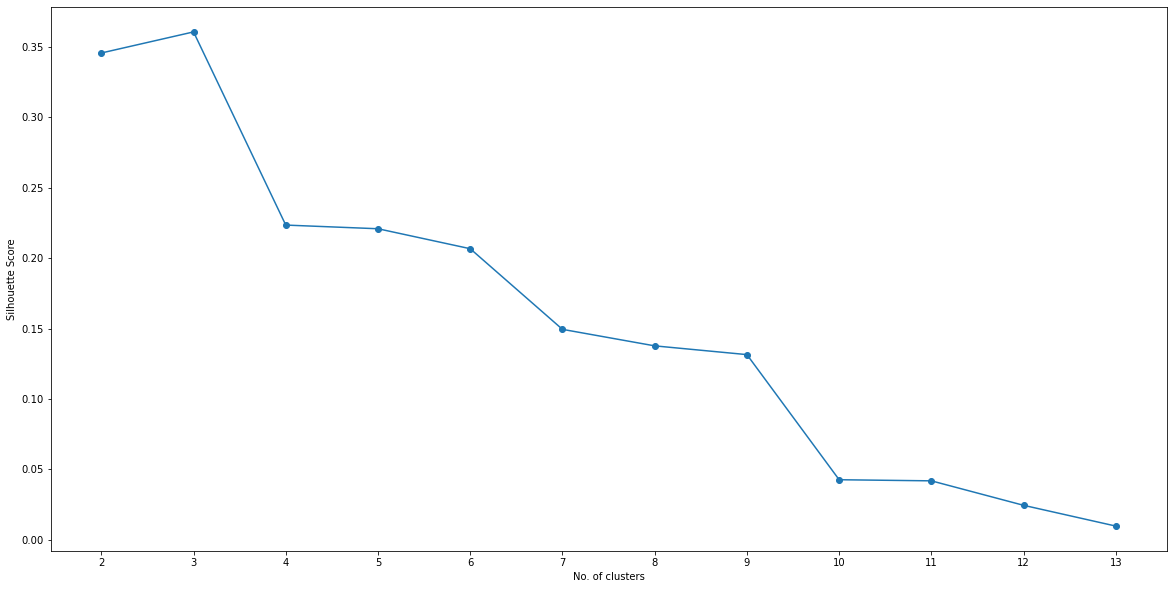

In [20]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Calculate the optimal number of clusters.

In [21]:
opt = np.argmax(scores) + 2 # Finds the optimal value of k
opt

3

### 4.1 Cluster the Neighborhoods

Run k-means to cluster the neighborhoods into 3 clusters.

In [22]:
kclusters = opt

# Run k-means clustering
kgc = Ljubljana_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [23]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [24]:
Ljubljana_merged = Ljubljana
Ljubljana_merged = Ljubljana_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')
Ljubljana_merged.dropna(inplace = True)
Ljubljana_merged['Cluster Labels'] = Ljubljana_merged['Cluster Labels'].astype(int)
Ljubljana_merged.head()

,City,Postcode,District,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ljubljana,1000,Bezigrad,46.077862,14.517007,0,Pizza Place,Convenience Store,Eastern European Restaurant,Café,Food & Drink Shop,Bus Station,Fast Food Restaurant,Gastropub,Basketball Stadium,Italian Restaurant
1,Ljubljana,1000,Center,46.047856,14.512180,0,Restaurant,Eastern European Restaurant,Plaza,Coffee Shop,Hostel,Café,Pizza Place,Chinese Restaurant,Vegetarian / Vegan Restaurant,Tea Room
3,Ljubljana,1000,Dravlje,46.075934,14.455358,0,Bar,Food & Drink Shop,Mobile Phone Shop,Athletics & Sports,Pharmacy,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant
4,Ljubljana,1000,Golovec,46.044281,14.556979,0,Gym,Pub,Bar,Chinese Restaurant,Athletics & Sports,Mexican Restaurant,Paintball Field,Music Venue,Mobile Phone Shop,Liquor Store
5,Ljubljana,1000,Jarse,46.073226,14.553944,0,Gym / Fitness Center,Restaurant,Athletics & Sports,Pharmacy,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant


### 4.1 Mapping the Clusters

In [25]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [26]:
Ljubljana_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Ljubljana_merged['Lat'], Ljubljana_merged['Long'], Ljubljana_merged['District'], Ljubljana_merged['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(Ljubljana_clusters)
        
Ljubljana_clusters

### 4.1 Examine the Clusters

The following produces a dataframe for each cluster, showing the top 10 venues of interest for each District within the cluster.
This view can be used by stakeholders to anlayse where they might most prefer to find accomodation during their stay.

### 4.1 Cluster 1

In [27]:
Ljubljana_merged.loc[Ljubljana_merged['Cluster Labels'] == 0, Ljubljana_merged.columns[[2] + list(range(5, Ljubljana_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bezigrad,0,Pizza Place,Convenience Store,Eastern European Restaurant,Café,Food & Drink Shop,Bus Station,Fast Food Restaurant,Gastropub,Basketball Stadium,Italian Restaurant
1,Center,0,Restaurant,Eastern European Restaurant,Plaza,Coffee Shop,Hostel,Café,Pizza Place,Chinese Restaurant,Vegetarian / Vegan Restaurant,Tea Room
3,Dravlje,0,Bar,Food & Drink Shop,Mobile Phone Shop,Athletics & Sports,Pharmacy,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant
4,Golovec,0,Gym,Pub,Bar,Chinese Restaurant,Athletics & Sports,Mexican Restaurant,Paintball Field,Music Venue,Mobile Phone Shop,Liquor Store
5,Jarse,0,Gym / Fitness Center,Restaurant,Athletics & Sports,Pharmacy,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant
6,Moste,0,Grocery Store,Café,Supermarket,Electronics Store,Department Store,Pharmacy,Restaurant,Pizza Place,Soccer Field,Music Venue
7,Polje,0,Soccer Field,Clothing Store,Italian Restaurant,Paintball Field,Music Venue,Mobile Phone Shop,Mexican Restaurant,Liquor Store,Athletics & Sports,Pharmacy
8,Posavje,0,Concert Hall,BBQ Joint,Athletics & Sports,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant,Liquor Store
9,Roznik,0,BBQ Joint,Trail,Restaurant,Park,Athletics & Sports,Italian Restaurant,Music Venue,Mobile Phone Shop,Mexican Restaurant,Liquor Store
12,Sentvid,0,Hotel,Coffee Shop,Bus Station,Hardware Store,Supermarket,Restaurant,Café,Paintball Field,Music Venue,Mobile Phone Shop


### 4.1 Cluster 2

In [28]:
Ljubljana_merged.loc[Ljubljana_merged['Cluster Labels'] == 1, Ljubljana_merged.columns[[2] + list(range(5, Ljubljana_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Vic,1,Paintball Field,Athletics & Sports,Pharmacy,Gym / Fitness Center,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant


### 4.1 Cluster 3

In [29]:
Ljubljana_merged.loc[Ljubljana_merged['Cluster Labels'] == 2, Ljubljana_merged.columns[[2] + list(range(5, Ljubljana_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Rudnik,2,Auto Garage,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,Hostel,Hotel,Indian Restaurant,Italian Restaurant


## 4.2 Data Collection - Villach

District & Lat/Lon dataframe

In [28]:
df_VL = pd.read_csv (r'https://raw.githubusercontent.com/nicwhitehead/IBM-Data-Science-Capstone-Project/main/Districts_and_Postcodes.csv')
#Limited to Villach for example purposes
Villach = df_VL[df_VL['City']=='Villach']
Villach.head()

,City,Postcode,District,Lat,Long
17,Villach,9601,Arnoldstein,46.554158,13.705619
18,Villach,9530,Bad Bleiberg,46.630598,13.679870
19,Villach,9584,Finkenstein am Faaker See,46.566703,13.871020
20,Villach,9611,Notsch im Gailtal,46.592694,13.622421
21,Villach,9711,Paternion,46.712130,13.638554


### 4.2 Create Map

In [29]:
address = 'Villach, Austria'
geolocator = Nominatim(user_agent="Villach_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [30]:
map_Villach = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, borough, neighborhood in zip(Villach['Lat'], Villach['Long'], Villach['City'], Villach['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Villach)  
map_Villach

Establish a connection to FourSquare using a previously created API

Return venues within 500m of each District’s Longitude and Latitude

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
Villach_venues = getNearbyVenues(names=Villach['District'],
                                   latitudes=Villach['Lat'],
                                   longitudes=Villach['Long']
                                  )

Arnoldstein
Bad Bleiberg
Finkenstein am Faaker See
Notsch im Gailtal
Paternion
Rosegg
Sankt Jakob im Rosental
Meeting
Velden am Worther See
Afritz am See
Arriach
Feistritz an der Gail
Feld am See
Ferndorf
Fresach
Hohenthurn
Stockenboi
Weisenstein
Wernberg


In [33]:
print(Villach_venues.shape)
Villach_venues.head()

(55, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arnoldstein,46.554158,13.705619,Wallner,46.550125,13.703234,Restaurant
1,Arnoldstein,46.554158,13.705619,Bahnhof Arnoldstein,46.551239,13.705898,Train Station
2,Arnoldstein,46.554158,13.705619,Rosi's Reinigungsservice - Gebäudereinigung - ...,46.555580,13.711420,Home Service
3,Bad Bleiberg,46.630598,13.679870,Bewegungsarena Bad Bleiberg,46.626497,13.678901,Athletics & Sports
4,Bad Bleiberg,46.630598,13.679870,Markus Stollen,46.629010,13.685822,Cave


In [34]:
Villach_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Afritz am See,3,3,3,3,3,3
Arnoldstein,3,3,3,3,3,3
Arriach,3,3,3,3,3,3
Bad Bleiberg,2,2,2,2,2,2
Feistritz an der Gail,3,3,3,3,3,3
Ferndorf,1,1,1,1,1,1
Finkenstein am Faaker See,1,1,1,1,1,1
Fresach,1,1,1,1,1,1
Meeting,15,15,15,15,15,15


In [35]:
# one hot encoding
Villach_onehot = pd.get_dummies(Villach_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Villach_onehot['Neighborhood'] = Villach_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Villach_onehot.columns[-1]] + list(Villach_onehot.columns[:-1])
Villach_onehot = Villach_onehot[fixed_columns]

Villach_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bar,Bed & Breakfast,Bistro,Café,Casino,Castle,Cave,Construction & Landscaping,Department Store,Eastern European Restaurant,Gastropub,German Restaurant,Greek Restaurant,Health & Beauty Service,Home Service,Hotel,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Pizza Place,Recording Studio,Restaurant,Shop & Service,Ski Area,Stables,Supermarket,Train Station
0,Arnoldstein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Arnoldstein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Arnoldstein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bad Bleiberg,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bad Bleiberg,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group the districts and calculate the mean of the frequency of occurrence of each category

In [36]:
Villach_grouped = Villach_onehot.groupby('Neighborhood').mean().reset_index()
Villach_grouped.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bar,Bed & Breakfast,Bistro,Café,Casino,Castle,Cave,Construction & Landscaping,Department Store,Eastern European Restaurant,Gastropub,German Restaurant,Greek Restaurant,Health & Beauty Service,Home Service,Hotel,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Pizza Place,Recording Studio,Restaurant,Shop & Service,Ski Area,Stables,Supermarket,Train Station
0,Afritz am See,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000
1,Arnoldstein,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.333333
2,Arriach,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,Bad Bleiberg,0.0,0.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,Feistritz an der Gail,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.666667,0.000000


Return each District with the frequency of occurrences of the venues of interest

In [37]:
num_top_venues = 5

for hood in Villach_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Villach_grouped[Villach_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Afritz am See----
                         venue  freq
0                  Supermarket  0.33
1  Eastern European Restaurant  0.33
2   Construction & Landscaping  0.33
3             Asian Restaurant  0.00
4         Other Great Outdoors  0.00


----Arnoldstein----
           venue  freq
0  Train Station  0.33
1   Home Service  0.33
2     Restaurant  0.33
3    Supermarket  0.00
4        Stables  0.00


----Arriach----
                     venue  freq
0  Health & Beauty Service  0.33
1      Austrian Restaurant  0.33
2                     Café  0.33
3              Pizza Place  0.00
4         Insurance Office  0.00


----Bad Bleiberg----
                venue  freq
0  Athletics & Sports   0.5
1                Cave   0.5
2      Ice Cream Shop   0.0
3    Insurance Office   0.0
4  Light Rail Station   0.0


----Feistritz an der Gail----
                  venue  freq
0           Supermarket  0.67
1      Department Store  0.33
2      Asian Restaurant  0.00
3  Other Great Outdoors  0.00
4      

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Stakeholders can then view the data as a pandas table to decide which area in the city might be best based on their lifestyle preferences.

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
V_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
V_neighborhoods_venues_sorted['Neighborhood'] = Villach_grouped['Neighborhood']

for ind in np.arange(Villach_grouped.shape[0]):
    V_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Villach_grouped.iloc[ind, :], num_top_venues)

V_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Afritz am See,Supermarket,Eastern European Restaurant,Construction & Landscaping,Asian Restaurant,Other Great Outdoors,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place
1,Arnoldstein,Train Station,Home Service,Restaurant,Supermarket,Stables,Ski Area,Shop & Service,Recording Studio,Pizza Place,Other Great Outdoors
2,Arriach,Health & Beauty Service,Austrian Restaurant,Café,Pizza Place,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Restaurant
3,Bad Bleiberg,Athletics & Sports,Cave,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Asian Restaurant,Hotel
4,Feistritz an der Gail,Supermarket,Department Store,Asian Restaurant,Other Great Outdoors,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place


### 4.2 Optimal Clusters

Calculating the optimal number of clusters for the venues found in the city of Villach

In [40]:
Villach_grouped_clustering = Villach_grouped.drop('Neighborhood', 1)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [42]:
max_range = 14

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = Villach_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

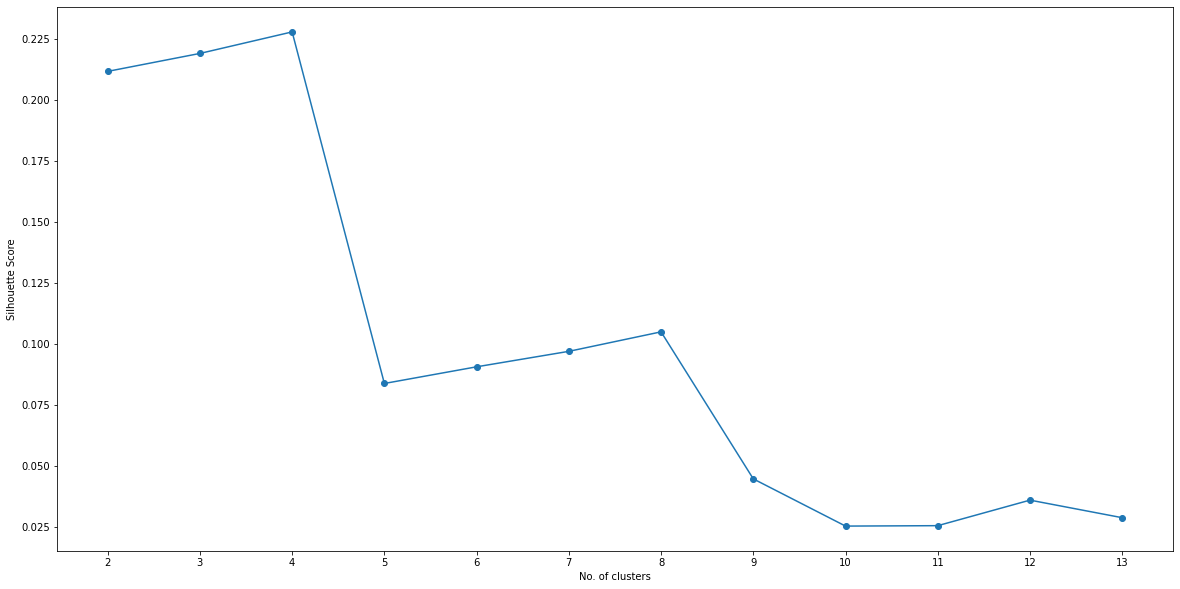

In [44]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Calculate the optimal number of clusters.

In [45]:
opt = np.argmax(scores) + 2 # Finds the optimal value of k
opt

4

### 4.2 Cluster the Neighborhoods

Run k-means to cluster the neighborhoods into 4 clusters.

In [46]:
kclusters = opt

# Run k-means clustering
kgc = Villach_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [47]:
V_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [48]:
Villach_merged = Villach
Villach_merged = Villach_merged.join(V_neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')
Villach_merged.dropna(inplace = True)
Villach_merged['Cluster Labels'] = Villach_merged['Cluster Labels'].astype(int)
Villach_merged.head()

,City,Postcode,District,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Villach,9601,Arnoldstein,46.554158,13.705619,0,Train Station,Home Service,Restaurant,Supermarket,Stables,Ski Area,Shop & Service,Recording Studio,Pizza Place,Other Great Outdoors
18,Villach,9530,Bad Bleiberg,46.630598,13.679870,0,Athletics & Sports,Cave,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Asian Restaurant,Hotel
19,Villach,9584,Finkenstein am Faaker See,46.566703,13.871020,3,German Restaurant,Asian Restaurant,Other Great Outdoors,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place,Home Service
20,Villach,9611,Notsch im Gailtal,46.592694,13.622421,0,Castle,Shop & Service,Restaurant,Pizza Place,Other Great Outdoors,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub
21,Villach,9711,Paternion,46.712130,13.638554,0,Train Station,Insurance Office,Ski Area,Construction & Landscaping,Other Great Outdoors,Ice Cream Shop,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place


### 4.2 Mapping the Clusters

In [49]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [53]:
Villach_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Villach_merged['Lat'], Villach_merged['Long'], Villach_merged['District'], Villach_merged['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(Villach_clusters)
        
Villach_clusters

### 4.2 Examine the Clusters

The following produces a dataframe for each cluster, showing the top 10 venues of interest for each District within the cluster.
This view can be used by stakeholders to anlayse where they might most prefer to find accomodation during their stay.

### 4.2 Cluster 1

In [54]:
Villach_merged.loc[Villach_merged['Cluster Labels'] == 0, Villach_merged.columns[[2] + list(range(5, Villach_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Arnoldstein,0,Train Station,Home Service,Restaurant,Supermarket,Stables,Ski Area,Shop & Service,Recording Studio,Pizza Place,Other Great Outdoors
18,Bad Bleiberg,0,Athletics & Sports,Cave,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Asian Restaurant,Hotel
20,Notsch im Gailtal,0,Castle,Shop & Service,Restaurant,Pizza Place,Other Great Outdoors,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub
21,Paternion,0,Train Station,Insurance Office,Ski Area,Construction & Landscaping,Other Great Outdoors,Ice Cream Shop,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place
24,Meeting,0,Café,Hotel,Train Station,Greek Restaurant,Gastropub,Mediterranean Restaurant,Other Great Outdoors,Ice Cream Shop,Restaurant,Supermarket
25,Velden am Worther See,0,Nightclub,Bar,Bistro,Café,Asian Restaurant,Casino,Restaurant,Pizza Place,Light Rail Station,Mediterranean Restaurant
26,Afritz am See,0,Supermarket,Eastern European Restaurant,Construction & Landscaping,Asian Restaurant,Other Great Outdoors,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place
27,Arriach,0,Health & Beauty Service,Austrian Restaurant,Café,Pizza Place,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Other Great Outdoors,Restaurant
28,Feistritz an der Gail,0,Supermarket,Department Store,Asian Restaurant,Other Great Outdoors,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place
31,Fresach,0,Restaurant,Asian Restaurant,Home Service,Supermarket,Stables,Ski Area,Shop & Service,Recording Studio,Pizza Place,Other Great Outdoors


### 4.2 Cluster 2

In [55]:
Villach_merged.loc[Villach_merged['Cluster Labels'] == 1, Villach_merged.columns[[2] + list(range(5, Villach_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Ferndorf,1,Light Rail Station,Asian Restaurant,Home Service,Supermarket,Stables,Ski Area,Shop & Service,Restaurant,Recording Studio,Pizza Place


### 4.2 Cluster 3

In [56]:
Villach_merged.loc[Villach_merged['Cluster Labels'] == 2, Villach_merged.columns[[2] + list(range(5, Villach_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Rosegg,2,Recording Studio,Asian Restaurant,Home Service,Supermarket,Stables,Ski Area,Shop & Service,Restaurant,Pizza Place,Other Great Outdoors


### 4.2 Cluster 4

In [57]:
Villach_merged.loc[Villach_merged['Cluster Labels'] == 3, Villach_merged.columns[[2] + list(range(5, Villach_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Finkenstein am Faaker See,3,German Restaurant,Asian Restaurant,Other Great Outdoors,Ice Cream Shop,Insurance Office,Light Rail Station,Mediterranean Restaurant,Nightclub,Pizza Place,Home Service


## 4.3 Data Collection - Maribor

District & Lat/Lon dataframe

In [3]:
df_MR = pd.read_csv (r'https://raw.githubusercontent.com/nicwhitehead/IBM-Data-Science-Capstone-Project/main/Districts_and_Postcodes.csv')
#Limited to Maribor for example purposes
Maribor = df_MR[df_MR['City']=='Maribor']
Maribor.head()

,City,Postcode,District,Lat,Long
36,Maribor,2000,Brezje Dogose Zrkovci,46.537131,15.700127
37,Maribor,2000,Center,46.568922,15.666684
38,Maribor,2000,Ivan Cankar,46.579261,15.669904
39,Maribor,2000,Koroska Vrata,46.567211,15.632624
40,Maribor,2000,Magdalena,46.554671,15.644152


### 4.3 Create Map

In [4]:
address = 'Maribor, Slovenia'
geolocator = Nominatim(user_agent="Maribor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [5]:
map_Maribor = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, borough, neighborhood in zip(Maribor['Lat'], Maribor['Long'], Maribor['City'], Maribor['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Maribor)  
map_Maribor

Establish a connection to FourSquare using a previously created API.

Return venues within 500m of each District’s Longitude and Latitude

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
Maribor_venues = getNearbyVenues(names=Maribor['District'],
                                   latitudes=Maribor['Lat'],
                                   longitudes=Maribor['Long']
                                  )

Brezje Dogose Zrkovci
Center
Ivan Cankar
Koroska Vrata
Magdalena
Nova Vas
Pobrezje
Radvanje
Studenci
Tabor
Tezno


In [8]:
print(Maribor_venues.shape)
Maribor_venues.head()

(82, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brezje Dogose Zrkovci,46.537131,15.700127,McDonald's,46.533370,15.699298,Fast Food Restaurant
1,Center,46.568922,15.666684,Simfonija Okusov,46.567274,15.661352,Indian Restaurant
2,Koroska Vrata,46.567211,15.632624,Kalvarija,46.565060,15.635038,Café
3,Koroska Vrata,46.567211,15.632624,Mitnica,46.566876,15.632009,Café
4,Koroska Vrata,46.567211,15.632624,Kalvarija,46.569667,15.634489,Trail


In [9]:
Maribor_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Brezje Dogose Zrkovci,1,1,1,1,1,1
Center,1,1,1,1,1,1
Koroska Vrata,4,4,4,4,4,4
Magdalena,44,44,44,44,44,44
Nova Vas,4,4,4,4,4,4
Pobrezje,5,5,5,5,5,5
Radvanje,2,2,2,2,2,2
Studenci,3,3,3,3,3,3
Tabor,14,14,14,14,14,14


In [10]:
# one hot encoding
Maribor_onehot = pd.get_dummies(Maribor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Maribor_onehot['Neighborhood'] = Maribor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Maribor_onehot.columns[-1]] + list(Maribor_onehot.columns[:-1])
Maribor_onehot = Maribor_onehot[fixed_columns]

Maribor_onehot.head()

,Neighborhood,Asian Restaurant,Bar,Beer Garden,Burger Joint,Café,Chinese Restaurant,Cocktail Bar,Comfort Food Restaurant,Department Store,Dessert Shop,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,General Entertainment,Grocery Store,Gym,Hotel,Hotel Bar,Hotel Pool,Indian Restaurant,Italian Restaurant,Jazz Club,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub,Restaurant,Scenic Lookout,Shoe Store,Shopping Mall,Speakeasy,Sporting Goods Shop,Supermarket,Theme Park,Trail,Vietnamese Restaurant,Vineyard,Wine Bar
0,Brezje Dogose Zrkovci,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Center,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Koroska Vrata,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Koroska Vrata,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Koroska Vrata,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Group the districts and calculate the mean of the frequency of occurrence of each category

In [11]:
Maribor_grouped = Maribor_onehot.groupby('Neighborhood').mean().reset_index()
Maribor_grouped.head()

,Neighborhood,Asian Restaurant,Bar,Beer Garden,Burger Joint,Café,Chinese Restaurant,Cocktail Bar,Comfort Food Restaurant,Department Store,Dessert Shop,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,General Entertainment,Grocery Store,Gym,Hotel,Hotel Bar,Hotel Pool,Indian Restaurant,Italian Restaurant,Jazz Club,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub,Restaurant,Scenic Lookout,Shoe Store,Shopping Mall,Speakeasy,Sporting Goods Shop,Supermarket,Theme Park,Trail,Vietnamese Restaurant,Vineyard,Wine Bar
0,Brezje Dogose Zrkovci,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000
1,Center,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000
2,Koroska Vrata,0.0,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.25,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.000000,0.000000,0.000000
3,Magdalena,0.0,0.204545,0.022727,0.0,0.068182,0.0,0.045455,0.022727,0.00,0.022727,0.045455,0.0,0.022727,0.022727,0.0,0.0,0.022727,0.022727,0.00,0.00,0.022727,0.0,0.0,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.00,0.045455,0.045455,0.113636,0.022727,0.0,0.0,0.022727,0.0,0.0,0.0,0.00,0.022727,0.022727,0.022727
4,Nova Vas,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.25,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000


Return each District with the frequency of occurrences of the venues of interest

In [12]:
num_top_venues = 5

for hood in Maribor_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Maribor_grouped[Maribor_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Brezje Dogose Zrkovci----
                      venue  freq
0      Fast Food Restaurant   1.0
1          Asian Restaurant   0.0
2        Italian Restaurant   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----Center----
                      venue  freq
0         Indian Restaurant   1.0
1                       Bar   0.0
2                 Jazz Club   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----Koroska Vrata----
              venue  freq
0              Café  0.50
1             Trail  0.25
2               Gym  0.25
3  Asian Restaurant  0.00
4        Restaurant  0.00


----Magdalena----
                         venue  freq
0                          Bar  0.20
1                   Restaurant  0.11
2                         Café  0.07
3                 Cocktail Bar  0.05
4  Eastern European Restaurant  0.05


----Nova Vas----
                           venue  freq
0                            Bar  0.25
1                         

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Stakeholders can then view the data as a pandas table to decide which area in the city might be best based on their lifestyle preferences.

In [14]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
M_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
M_neighborhoods_venues_sorted['Neighborhood'] = Maribor_grouped['Neighborhood']

for ind in np.arange(Maribor_grouped.shape[0]):
    M_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Maribor_grouped.iloc[ind, :], num_top_venues)

M_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brezje Dogose Zrkovci,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub
1,Center,Indian Restaurant,Bar,Jazz Club,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub
2,Koroska Vrata,Café,Trail,Gym,Asian Restaurant,Restaurant,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store
3,Magdalena,Bar,Restaurant,Café,Cocktail Bar,Eastern European Restaurant,Pub,Pizza Place,Nightclub,Museum,Grocery Store
4,Nova Vas,Bar,Hotel,Paper / Office Supplies Store,Department Store,Scenic Lookout,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Pizza Place


### 4.3 Optimal Clusters

Calculating the optimal number of clusters for the venues found in the city of Maribor

In [15]:
Maribor_grouped_clustering = Maribor_grouped.drop('Neighborhood', 1)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [20]:
max_range = 10

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = Maribor_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

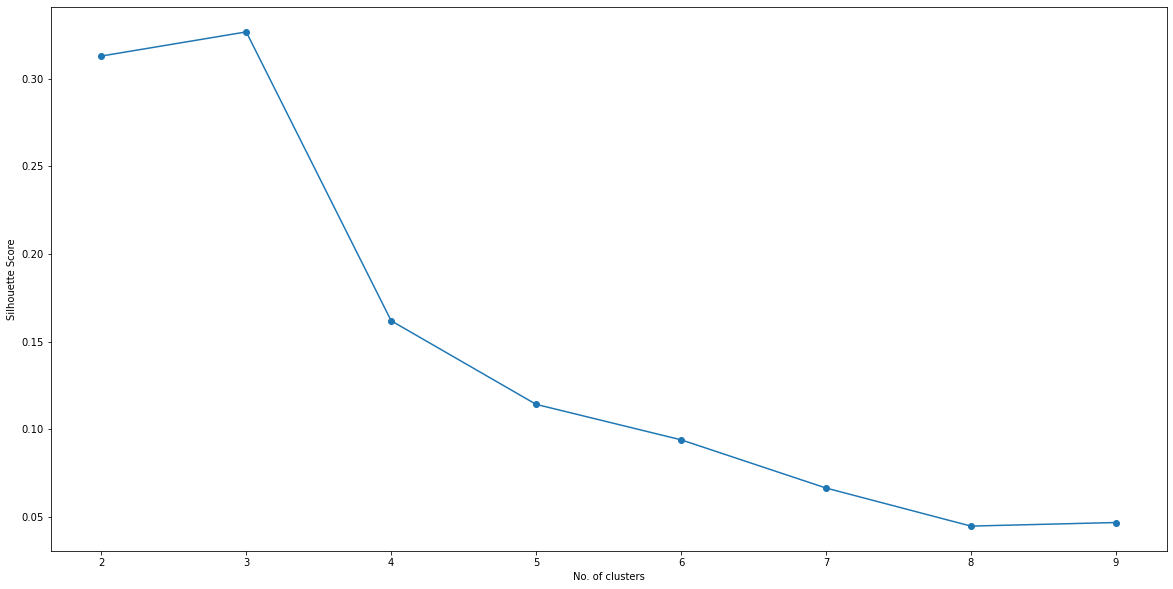

In [22]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [23]:
opt = np.argmax(scores) + 2 # Finds the optimal value of k
opt

3

### 4.3 Cluster the Neighborhoods

Run k-means to cluster the neighborhoods into 3 clusters.

In [24]:
kclusters = opt

# Run k-means clustering
kgc = Maribor_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
M_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [26]:
Maribor_merged = Maribor
Maribor_merged = Maribor_merged.join(M_neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')
Maribor_merged.dropna(inplace = True)
Maribor_merged['Cluster Labels'] = Maribor_merged['Cluster Labels'].astype(int)
Maribor_merged.head()

,City,Postcode,District,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Maribor,2000,Brezje Dogose Zrkovci,46.537131,15.700127,1,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub
37,Maribor,2000,Center,46.568922,15.666684,2,Indian Restaurant,Bar,Jazz Club,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub
39,Maribor,2000,Koroska Vrata,46.567211,15.632624,0,Café,Trail,Gym,Asian Restaurant,Restaurant,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store
40,Maribor,2000,Magdalena,46.554671,15.644152,0,Bar,Restaurant,Café,Cocktail Bar,Eastern European Restaurant,Pub,Pizza Place,Nightclub,Museum,Grocery Store
41,Maribor,2000,Nova Vas,46.541146,15.630192,0,Bar,Hotel,Paper / Office Supplies Store,Department Store,Scenic Lookout,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Pizza Place


### 4.3 Mapping the Clusters

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [28]:
Maribor_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Maribor_merged['Lat'], Maribor_merged['Long'], Maribor_merged['District'], Maribor_merged['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(Maribor_clusters)
        
Maribor_clusters

### 4.3 Examine the Clusters

The following produces a dataframe for each cluster, showing the top 10 venues of interest for each District within the cluster.
This view can be used by stakeholders to anlayse where they might most prefer to find accomodation during their stay.

### 4.3 Cluster 1

In [29]:
Maribor_merged.loc[Maribor_merged['Cluster Labels'] == 0, Maribor_merged.columns[[2] + list(range(5, Maribor_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Koroska Vrata,0,Café,Trail,Gym,Asian Restaurant,Restaurant,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store
40,Magdalena,0,Bar,Restaurant,Café,Cocktail Bar,Eastern European Restaurant,Pub,Pizza Place,Nightclub,Museum,Grocery Store
41,Nova Vas,0,Bar,Hotel,Paper / Office Supplies Store,Department Store,Scenic Lookout,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Pizza Place
42,Pobrezje,0,Café,Gym,Nightclub,Pub,Restaurant,Asian Restaurant,Scenic Lookout,Mediterranean Restaurant,Mexican Restaurant,Museum
43,Radvanje,0,Café,Fried Chicken Joint,Asian Restaurant,Scenic Lookout,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place
44,Studenci,0,Asian Restaurant,Theme Park,Hotel Pool,Vietnamese Restaurant,Pub,Jazz Club,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub
45,Tabor,0,Shopping Mall,Bar,Sporting Goods Shop,Electronics Store,Eastern European Restaurant,Shoe Store,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Café
46,Tezno,0,Asian Restaurant,Restaurant,Supermarket,Food & Drink Shop,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place


### 4.3 Cluster 2

In [30]:
Maribor_merged.loc[Maribor_merged['Cluster Labels'] == 1, Maribor_merged.columns[[2] + list(range(5, Maribor_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Brezje Dogose Zrkovci,1,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub


### 4.3 Cluster 3

In [31]:
Maribor_merged.loc[Maribor_merged['Cluster Labels'] == 2, Maribor_merged.columns[[2] + list(range(5, Maribor_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Center,2,Indian Restaurant,Bar,Jazz Club,Mediterranean Restaurant,Mexican Restaurant,Museum,Nightclub,Paper / Office Supplies Store,Pizza Place,Pub


## 4.4 Data Collection - Graz

District & Lat/Lon dataframe

In [3]:
df_GR = pd.read_csv (r'https://raw.githubusercontent.com/nicwhitehead/IBM-Data-Science-Capstone-Project/main/Districts_and_Postcodes.csv')
#Limited to Graz for example purposes
Graz = df_GR[df_GR['City']=='Graz']
Graz.head()

,City,Postcode,District,Lat,Long
47,Graz,8010,Innere Stadt,47.067290,15.441683
48,Graz,8010,St. Leonhard,47.069483,15.458977
49,Graz,8010,Geidorf,47.084729,15.443990
50,Graz,8020,Lend,47.083779,15.415516
51,Graz,8020,Gries,47.063575,15.423993


### 4.4 Create Map

In [4]:
address = 'Graz, Austria'
geolocator = Nominatim(user_agent="Graz_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [5]:
map_Graz = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, borough, neighborhood in zip(Graz['Lat'], Graz['Long'], Graz['City'], Graz['District']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Graz)  
map_Graz

Establish a connection to FourSquare using a previously created API.

Return venues within 500m of each District’s Longitude and Latitude.

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
Graz_venues = getNearbyVenues(names=Graz['District'],
                                   latitudes=Graz['Lat'],
                                   longitudes=Graz['Long']
                                  )

Innere Stadt
St. Leonhard
Geidorf
Lend
Gries
Jakomini
Liebenau
St. Peter
Waltendorf
Ries
Mariatrost
Andritz
Gosting
Eggenberg
Wetzelsdorf
Strasgang
Puntigam


In [8]:
print(Graz_venues.shape)
Graz_venues.head()

(164, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,47.06729,15.441683,Tribeka,47.068267,15.440954,Coffee Shop
1,Innere Stadt,47.06729,15.441683,John Harris Fitness,47.068750,15.444530,Gym / Fitness Center
2,Innere Stadt,47.06729,15.441683,Feinkost Mild,47.068479,15.440275,Sandwich Place
3,Innere Stadt,47.06729,15.441683,FITINN Fitnessstudio,47.067528,15.443716,Gym
4,Innere Stadt,47.06729,15.441683,Die Eisperle,47.067538,15.438523,Ice Cream Shop


In [9]:
Graz_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Andritz,4,4,4,4,4,4
Eggenberg,4,4,4,4,4,4
Geidorf,5,5,5,5,5,5
Gosting,3,3,3,3,3,3
Gries,26,26,26,26,26,26
Innere Stadt,54,54,54,54,54,54
Jakomini,8,8,8,8,8,8
Lend,3,3,3,3,3,3
Liebenau,4,4,4,4,4,4


In [10]:
# one hot encoding
Graz_onehot = pd.get_dummies(Graz_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Graz_onehot['Neighborhood'] = Graz_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Graz_onehot.columns[-1]] + list(Graz_onehot.columns[:-1])
Graz_onehot = Graz_onehot[fixed_columns]

Graz_onehot.head()

,Neighborhood,Airport Service,Art Gallery,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Drugstore,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Light Rail Station,Market,Mobile Phone Shop,Movie Theater,Multiplex,Music Venue,Nightclub,Opera House,Park,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pool Hall,Pub,Restaurant,Rock Club,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Soccer Field,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store
0,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group the districts and calculate the mean of the frequency of occurrence of each category

In [11]:
Graz_grouped = Graz_onehot.groupby('Neighborhood').mean().reset_index()
Graz_grouped.head()

,Neighborhood,Airport Service,Art Gallery,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Drugstore,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Light Rail Station,Market,Mobile Phone Shop,Movie Theater,Multiplex,Music Venue,Nightclub,Opera House,Park,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pool Hall,Pub,Restaurant,Rock Club,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Soccer Field,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store
0,Andritz,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Eggenberg,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Geidorf,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.20,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Gosting,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0
4,Gries,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.038462,0.153846,0.000000,0.038462,0.076923,0.0,0.038462,0.038462,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.038462,0.038462,0.0,0.0,0.038462,0.0,0.0,0.038462,0.0,0.0,0.0,0.038462,0.0,0.00,0.0,0.0,0.076923,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.038462,0.038462,0.0,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,0.038462,0.0,0.0


Return each District with the frequency of occurrences of the venues of interest

In [12]:
num_top_venues = 5

for hood in Graz_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Graz_grouped[Graz_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Andritz----
                venue  freq
0  Italian Restaurant  0.25
1                Café  0.25
2         Supermarket  0.25
3           Gastropub  0.25
4                Park  0.00


----Eggenberg----
             venue  freq
0             Park  0.25
1   History Museum  0.25
2             Café  0.25
3       Restaurant  0.25
4  Airport Service  0.00


----Geidorf----
                venue  freq
0  Italian Restaurant   0.2
1  Seafood Restaurant   0.2
2                Café   0.2
3         Supermarket   0.2
4                Park   0.2


----Gosting----
                venue  freq
0  Chinese Restaurant  0.33
1                Café  0.33
2         Supermarket  0.33
3     Airport Service  0.00
4                Park  0.00


----Gries----
            venue  freq
0            Café  0.15
1     Pizza Place  0.08
2  Clothing Store  0.08
3      Shoe Store  0.04
4    Climbing Gym  0.04


----Innere Stadt----
                 venue  freq
0  Austrian Restaurant  0.11
1                Plaza  0.07
2   

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Stakeholders can then view the data as a pandas table to decide which area in the city might be best based on their lifestyle preferences.

In [14]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
G_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
G_neighborhoods_venues_sorted['Neighborhood'] = Graz_grouped['Neighborhood']

for ind in np.arange(Graz_grouped.shape[0]):
    G_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Graz_grouped.iloc[ind, :], num_top_venues)

G_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andritz,Italian Restaurant,Café,Supermarket,Gastropub,Park,Pool Hall,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
1,Eggenberg,Park,History Museum,Café,Restaurant,Airport Service,Pool Hall,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
2,Geidorf,Italian Restaurant,Seafood Restaurant,Café,Supermarket,Park,Opera House,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
3,Gosting,Chinese Restaurant,Café,Supermarket,Airport Service,Park,Pool Hall,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
4,Gries,Café,Pizza Place,Clothing Store,Shoe Store,Climbing Gym,Mobile Phone Shop,Italian Restaurant,Art Gallery,Hotel,Hot Dog Joint


### 4.4 Optimal Clusters

Calculating the optimal number of clusters for the venues found in the city of Maribor

In [15]:
Graz_grouped_clustering = Graz_grouped.drop('Neighborhood', 1)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [17]:
max_range = 17

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = Graz_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

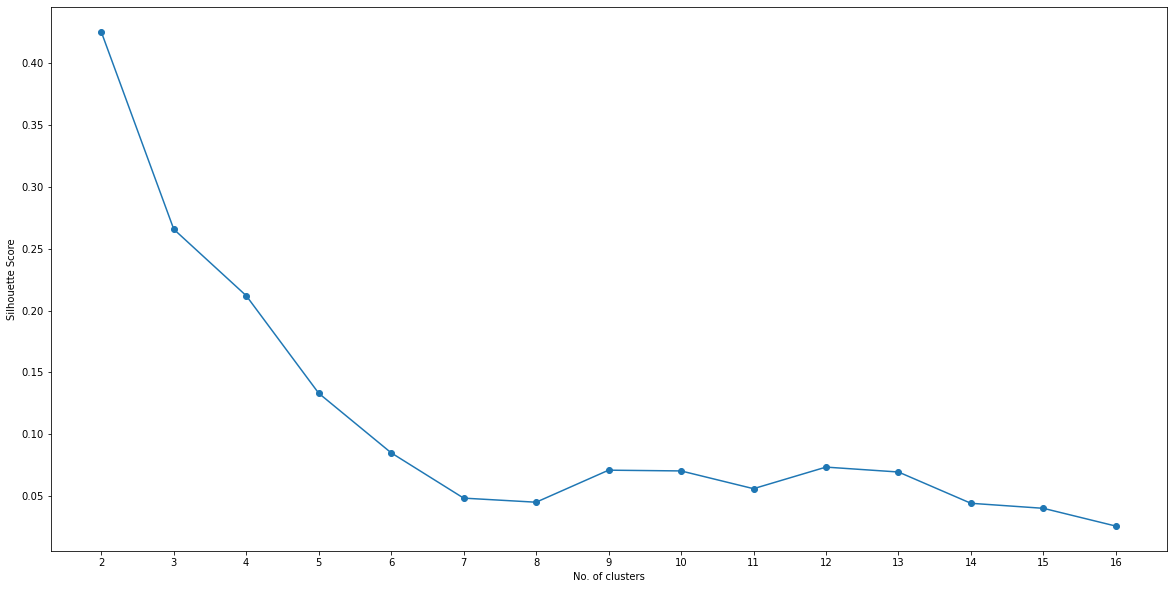

In [19]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [20]:
opt = np.argmax(scores) + 2 # Finds the optimal value of k
opt

2

### 4.4 Cluster the Neigborhoods

Run k-means to cluster the neighborhoods into 2 clusters.

In [21]:
kclusters = opt

# Run k-means clustering
kgc = Graz_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [22]:
G_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [23]:
Graz_merged = Graz
Graz_merged = Graz_merged.join(G_neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')
Graz_merged.dropna(inplace = True)
Graz_merged['Cluster Labels'] = Graz_merged['Cluster Labels'].astype(int)
Graz_merged.head()

,City,Postcode,District,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Graz,8010,Innere Stadt,47.067290,15.441683,1,Austrian Restaurant,Plaza,Bar,Café,Greek Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Bakery,Steakhouse,Rock Club
48,Graz,8010,St. Leonhard,47.069483,15.458977,1,Café,Light Rail Station,Supermarket,Plaza,Bakery,Gastropub,Basketball Court,Park,Airport Service,Pool Hall
49,Graz,8010,Geidorf,47.084729,15.443990,1,Italian Restaurant,Seafood Restaurant,Café,Supermarket,Park,Opera House,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
50,Graz,8020,Lend,47.083779,15.415516,1,Pizza Place,Supermarket,Airport Service,Opera House,Pool Hall,Plaza,Pharmacy,Peruvian Restaurant,Park,Nightclub
51,Graz,8020,Gries,47.063575,15.423993,1,Café,Pizza Place,Clothing Store,Shoe Store,Climbing Gym,Mobile Phone Shop,Italian Restaurant,Art Gallery,Hotel,Hot Dog Joint


### 4.4 Mapping the Clusters

In [24]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [25]:
Graz_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Graz_merged['Lat'], Graz_merged['Long'], Graz_merged['District'], Graz_merged['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(Graz_clusters)
        
Graz_clusters

### 4.4 Examine the Clusters

The following produces a dataframe for each cluster, showing the top 10 venues of interest for each District within the cluster. This view can be used by stakeholders to anlayse where they might most prefer to find accomodation during their stay.

### 4.4 Cluster 1

In [26]:
Graz_merged.loc[Graz_merged['Cluster Labels'] == 0, Graz_merged.columns[[2] + list(range(5, Graz_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Ries,0,Grocery Store,Airport Service,Opera House,Pool Hall,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant,Park,Nightclub


### 4.4 Cluster 2

In [27]:
Graz_merged.loc[Graz_merged['Cluster Labels'] == 1, Graz_merged.columns[[2] + list(range(5, Graz_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Innere Stadt,1,Austrian Restaurant,Plaza,Bar,Café,Greek Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Bakery,Steakhouse,Rock Club
48,St. Leonhard,1,Café,Light Rail Station,Supermarket,Plaza,Bakery,Gastropub,Basketball Court,Park,Airport Service,Pool Hall
49,Geidorf,1,Italian Restaurant,Seafood Restaurant,Café,Supermarket,Park,Opera House,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
50,Lend,1,Pizza Place,Supermarket,Airport Service,Opera House,Pool Hall,Plaza,Pharmacy,Peruvian Restaurant,Park,Nightclub
51,Gries,1,Café,Pizza Place,Clothing Store,Shoe Store,Climbing Gym,Mobile Phone Shop,Italian Restaurant,Art Gallery,Hotel,Hot Dog Joint
52,Jakomini,1,Hotel,Tram Station,Supermarket,Fast Food Restaurant,Event Space,Airport Service,Park,Plaza,Pizza Place,Pharmacy
53,Liebenau,1,Grocery Store,Café,Falafel Restaurant,Italian Restaurant,Movie Theater,Multiplex,Music Venue,Nightclub,Opera House,Pub
54,St. Peter,1,Soccer Field,Supermarket,Hotel,Italian Restaurant,Café,Airport Service,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
55,Waltendorf,1,Austrian Restaurant,Trattoria/Osteria,Pharmacy,Gastropub,Airport Service,Park,Pool Hall,Plaza,Pizza Place,Peruvian Restaurant
57,Mariatrost,1,Bus Station,Austrian Restaurant,Supermarket,Breakfast Spot,Airport Service,Pool Hall,Plaza,Pizza Place,Pharmacy,Peruvian Restaurant
